In [1]:
import numpy as np
import pickle as pk
from matplotlib import pyplot as plt

from astropy import units as u
from astropy.modeling.physical_models import BlackBody
from astropy.time import Time
import astropy.table as tb

from asteroid_utils_pixell import  get_desig

from pixell import utils

import requests, json, os

from phase_curves import get_period

from astroquery.jplhorizons import Horizons
from astroquery.jplsbdb import SBDB

import seaborn as sns
sns.set_theme(style="ticks")

[nia-jupyter.scinet.local:248345] pml_ucx.c:285  Error: UCP worker does not support MPI_THREAD_MULTIPLE


In [2]:
def inv_var(data, variances):
    ave = 0
    var = 0
    for i in range(len(data)):
        ave += data[i]/variances[i]**2
        var += 1/variances[i]**2
    return ave/var, np.sqrt(1/var)
        

In [3]:
class QueryHorizons:
    '''
    Constructs a class that can query a bunch of positions for objects from JPL-Horizons given a set of times and an observatory location
    '''

    def __init__(self, time_start, time_end, observer_location, step = '1d'):
        '''
        Initialization function

        Arguments:
        - time_start: start time for the query, should be in MJD
        - time_end: end time for the query, should be in MJD
        - observer_location: location of the observer
        - step: time step for the ephemeris
        The simples way to get the observer location variable is via the
        list of IAU observatory codes: https://en.wikipedia.org/wiki/List_of_observatory_codes

        Custom locations are also accepted by JPL
        '''
        if type(time_start) == str:
            t_st = Time(time_start, format='isot', scale='utc')

        else:
            t_st = Time(time_start, format='mjd')
        self.time_start = t_st.utc.iso
        if type(time_end) == str:
            t_en = Time(time_end, format='isot', scale='utc')

        else:
            t_en = Time(time_end, format='mjd')

        self.time_end = t_en.utc.iso

        self.observer = observer_location

        self.step = step


    def queryObjects(self, objects):
        '''
        Returns a table (and saves it on the object as well) for the provided list of objects
        '''
        self.table = []

        for i in objects:
            query = Horizons(id = i, location = self.observer,
                epochs = {'start' : self.time_start, 'stop' : self.time_end, 'step' : self.step})

            eph = query.ephemerides()

            self.table.append(eph['RA', 'DEC', 'datetime_jd', 'targetname', 'delta', 'r', 'alpha'])

        self.table = tb.vstack(self.table)

        return self.table


In [4]:
with open('./pks/ast_stats.pk', 'rb') as f:
    ast_stats = pk.load(f)

ast_groups = {'B':'C', 'C':'C', 'D':'C', 'F':'C', 'G':'C', 'T':'C',
             'A':'S', 'Q':'S', 'R':'S', 'S':'S', 'V':'S',
             'E':'X', 'M':'X', 'P':'X', 'X':'X'}
color_mapping = {'C':'tab:red', 'S':'tab:blue', 'X':'tab:green'}

names = []
sn_090 = []
sn_150 = []
sn_220 = []

tot_sn = []

rel_delta_090 = []
rel_delta_150 = []
rel_delta_220 = []

rel_delta_090_err = []
rel_delta_150_err = []
rel_delta_220_err = []

stat_rel_delta_090_err = []
stat_rel_delta_150_err = []
stat_rel_delta_220_err = []

tholens = []
smasses = []
groups = []

colors = []

flux_090 = []
flux_150 = []
flux_220 = []

flux_090_err = []
flux_150_err = []
flux_220_err = []

for i, name in enumerate(ast_stats.keys()):
    #print(ast_stats[name]['tholen'])
    if ast_stats[name]['tholen'] == '0': continue
    if ast_stats[name]['tholen'].strip(':')[0] not in ast_groups.keys(): continue

    names.append(name)
    rel_delta_090.append(ast_stats[name]['090'][0])
    rel_delta_150.append(ast_stats[name]['150'][0])
    rel_delta_220.append(ast_stats[name]['220'][0])
    
    rel_delta_090_err.append(ast_stats[name]['090'][1])
    rel_delta_150_err.append(ast_stats[name]['150'][1])
    rel_delta_220_err.append(ast_stats[name]['220'][1])
    
    flux_090.append(ast_stats[name]['flux_090'][0])
    flux_150.append(ast_stats[name]['flux_150'][0])
    flux_220.append(ast_stats[name]['flux_220'][0])
    
    flux_090_err.append(ast_stats[name]['flux_090'][1])
    flux_150_err.append(ast_stats[name]['flux_150'][1])
    flux_220_err.append(ast_stats[name]['flux_220'][1])
    
    sn_090.append(ast_stats[name]['sn_090'])
    sn_150.append(ast_stats[name]['sn_150'])
    sn_220.append(ast_stats[name]['sn_220'])
    
    tot_sn.append(ast_stats[name]['tot_sn'])
    
    tholens.append(ast_stats[name]['tholen'].strip(':'))
    smasses.append(ast_stats[name]['smass'])
    
    groups.append(ast_groups[tholens[-1][0]])
    colors.append(color_mapping[groups[-1]])
    
sn_090 = np.array(sn_090)
sn_150 = np.array(sn_150)
sn_220 = np.array(sn_220)

tot_sn = np.array(tot_sn)

rel_delta_090 = np.array(rel_delta_090)
rel_delta_150 = np.array(rel_delta_150)
rel_delta_220 = np.array(rel_delta_220)

rel_delta_090_err = np.array(rel_delta_090_err)
rel_delta_150_err = np.array(rel_delta_150_err)
rel_delta_220_err = np.array(rel_delta_220_err)


names = np.array(names)
groups = np.array(groups)
colors = np.array(colors)


In [5]:
flags_C = np.where((groups == 'C'))
flags_S = np.where((groups == 'S'))

sn_cut = 5

C_sn5 = [i for i in range(len(rel_delta_090)) if tholens[i] == 'C' and tot_sn[i] >= sn_cut]
S_sn5 = [i for i in range(len(rel_delta_090)) if tholens[i] == 'S' and tot_sn[i] >= sn_cut]

sn_cut = 0

C_sn0 = [i for i in range(len(rel_delta_090)) if tholens[i] == 'C' and tot_sn[i] >= sn_cut]
S_sn0 = [i for i in range(len(rel_delta_090)) if tholens[i] == 'S' and tot_sn[i] >= sn_cut]

In [6]:
print('# C: {}'.format(len(C_sn5)))
print('# S: {}'.format(len(S_sn5)))


# C: 63
# S: 20


In [7]:
name = names[0]

eph_table = QueryHorizons(time_start='2010-01-01T00:00:00', time_end='2020-01-01T00:00:00', observer_location='W99', step = '1d').queryObjects([str(name)])


In [8]:
diams_C = []
rads_C = []

diams_S = []
rads_S = []

C_sn = []
S_sn = []

for idx in C_sn0:
    name = names[idx]
    sbdb = SBDB.query(str(name), phys=True)
    if 'diameter' in sbdb['phys_par'].keys(): 
        diams_C.append(sbdb['phys_par']['diameter'].value)
    else:
        print('No diamter for ', name)
        continue
    
    a = sbdb['orbit']['elements']['a']
    e = sbdb['orbit']['elements']['e']

    rads_C.append((a*(1+1/2*e**2)).value)
    C_sn.append(tot_sn[idx])
    
for idx in S_sn0:
    name = names[idx]
    sbdb = SBDB.query(str(name), phys=True)
    
    if 'diameter' in sbdb['phys_par'].keys(): 
        diams_S.append(sbdb['phys_par']['diameter'].value)
        
    else:
        print('No diamter for ', name)
        continue
    
    a = sbdb['orbit']['elements']['a']
    e = sbdb['orbit']['elements']['e']

    rads_S.append((a*(1+1/2*e**2)).value)
    S_sn.append(tot_sn[idx])

No diamter for  Atami


In [9]:
len(rads_S)

167

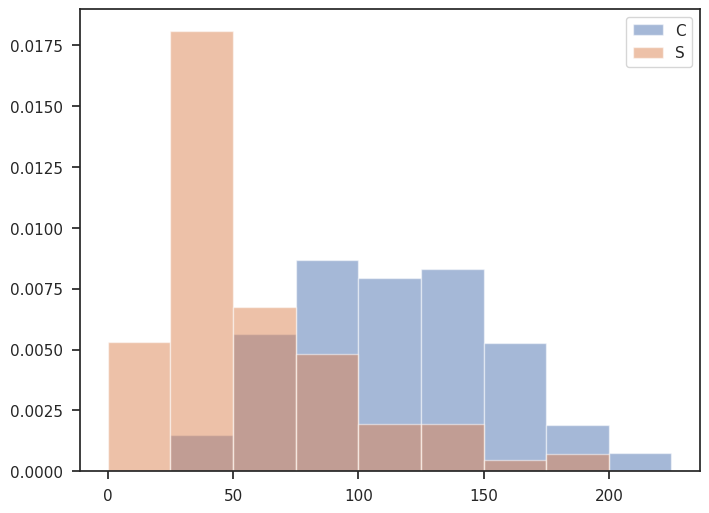

In [10]:
bins = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225]

plt.hist(diams_C, label = 'C', density = True, bins = bins, alpha = 0.5)
plt.hist(diams_S, label = 'S', density = True, bins = bins, alpha = 0.5)
plt.legend()
plt.show()

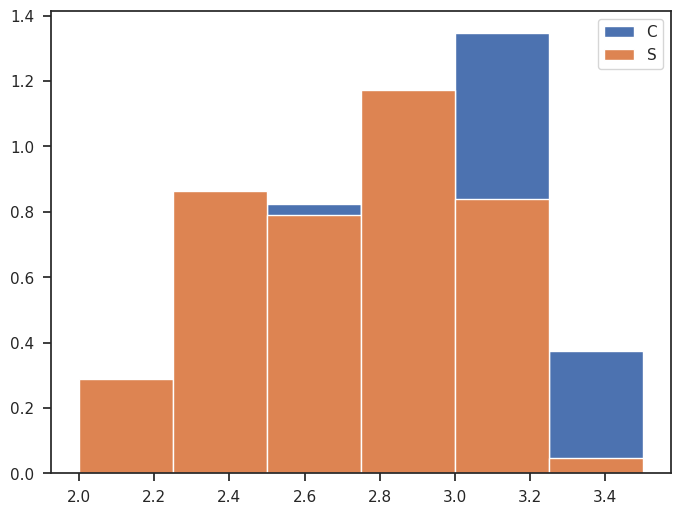

In [11]:
bins = np.arange(2.0, 3.75, 0.25)

plt.hist(rads_C, label = 'C', density = True, bins = bins)
plt.hist(rads_S, label = 'S', density = True, bins = bins)
plt.legend()
plt.show()

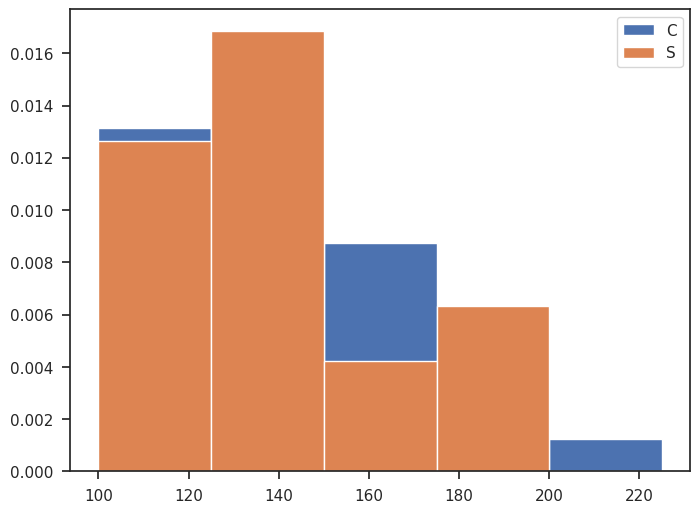

In [12]:
bins = [100, 125, 150, 175, 200, 225]

plt.hist(sorted(diams_C)[-68:], label = 'C', density = True, bins = bins)
plt.hist(sorted(diams_S)[-20:], label = 'S', density = True, bins = bins)
plt.legend()
plt.show()

In [13]:
stat_C = np.zeros(len(diams_C))
stat_S = np.zeros(len(diams_S))

for i in range(len(stat_C)):
    stat_C[i] = (diams_C[i])**2/rads_C[i]**2
    
for i in range(len(stat_S)):
    stat_S[i] = (diams_S[i])**2/rads_S[i]**2

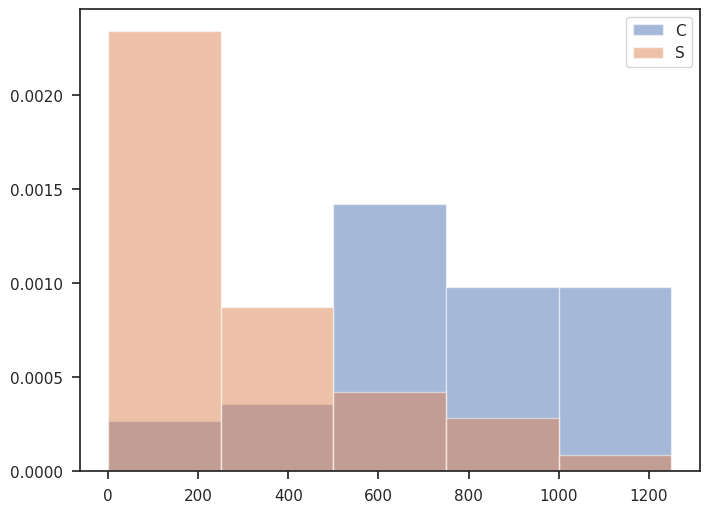

In [14]:
bins = np.arange(0, 1500, 250)

plt.hist(stat_C, label = 'C', density = True, alpha = 0.5, bins = bins)
plt.hist(stat_S, label = 'S', density = True, alpha = 0.5, bins = bins)
plt.legend()
plt.show()

In [15]:
sorted(stat_C)[-68]

1142.3415914097957

In [16]:
len(stat_S[stat_S > sorted(stat_C)[-68]])

26

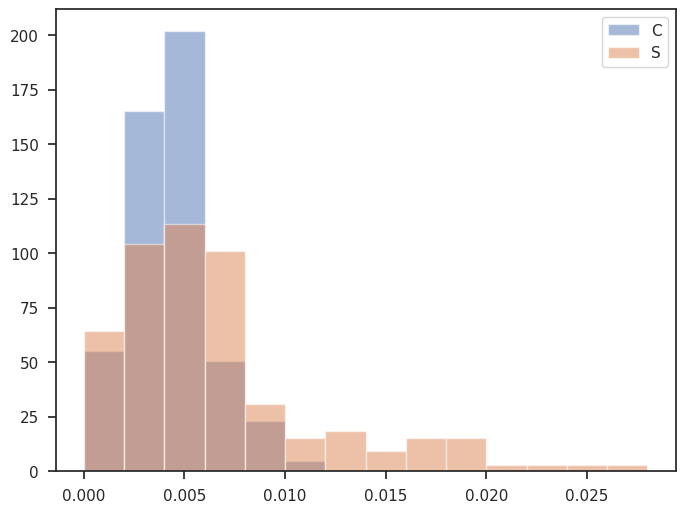

In [17]:
bins = np.arange(0, 0.03, 0.002)

plt.hist(np.array(C_sn)/np.array(stat_C), density = True, label = 'C', alpha = 0.5, bins = bins)
plt.hist(np.array(S_sn)/np.array(stat_S), density = True, label = 'S', alpha = 0.5, bins = bins)
plt.legend()
plt.show()

In [18]:
from scipy.stats import kstest

In [19]:
kstest(np.array(C_sn)/np.array(stat_C), np.array(S_sn)/np.array(stat_S))

KstestResult(statistic=0.3107180135142559, pvalue=3.819558204417107e-06, statistic_location=0.005848359412537049, statistic_sign=1)

(array([ 3., 12., 21., 31., 19.,  9.,  8.,  2.,  3.,  1.]),
 array([0.        , 0.00113881, 0.00227762, 0.00341643, 0.00455525,
        0.00569406, 0.00683287, 0.00797168, 0.00911049, 0.0102493 ,
        0.01138812]),
 <BarContainer object of 10 artists>)

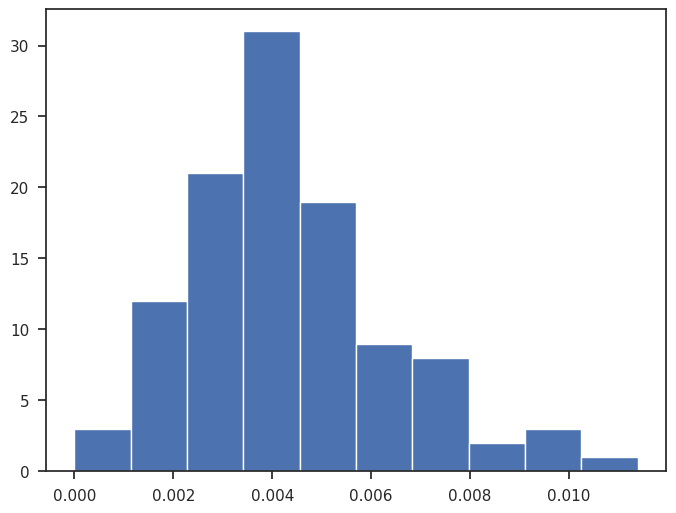

In [20]:
plt.hist(np.array(C_sn)/np.array(stat_C))

In [32]:
kstest(np.array(C_sn)/np.mean(C_sn), np.array(stat_C)/np.mean(stat_C))

KstestResult(statistic=0.07339449541284404, pvalue=0.9325712647984811, statistic_location=0.8121535995736245, statistic_sign=1)

(array([71., 33.,  2.,  2.,  0.,  0.,  0.,  0.,  1.]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 <BarContainer object of 9 artists>)

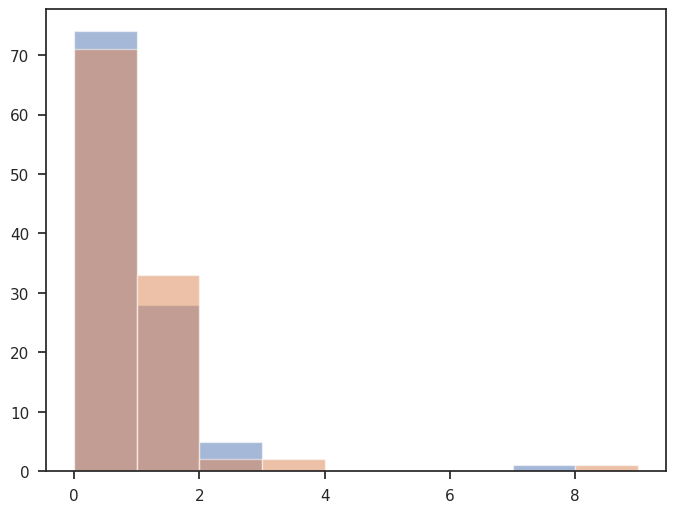

In [30]:
plt.hist(C_sn/np.mean(C_sn), alpha = 0.5, bins = bins)
plt.hist(stat_C/np.mean(stat_C), alpha = 0.5, bins = bins)

(array([126.,  19.,   4.,   7.,   4.,   3.,   1.,   2.,   0.]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 <BarContainer object of 9 artists>)

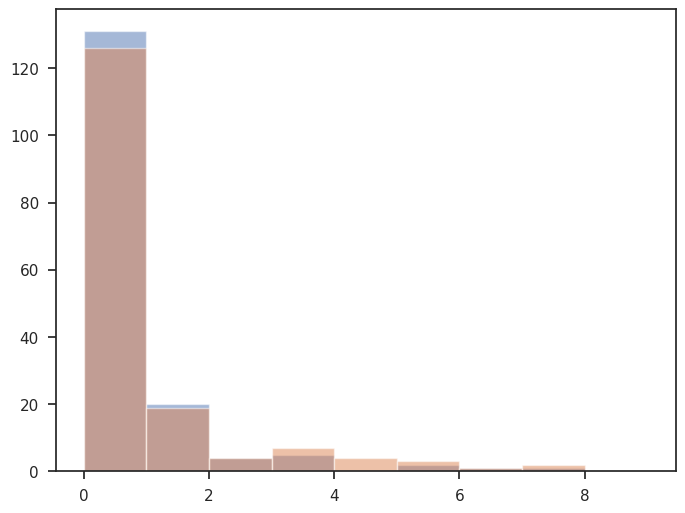

In [29]:
bins = np.arange(0, 10, 1)

plt.hist(S_sn/np.mean(S_sn), alpha = 0.5, bins = bins)
plt.hist(stat_S/np.mean(stat_S), alpha = 0.5, bins = bins)

In [33]:
kstest(np.array(S_sn)/np.mean(S_sn), np.array(stat_S)/np.mean(stat_S))

KstestResult(statistic=0.19161676646706588, pvalue=0.004262034217257377, statistic_location=0.28731508013546514, statistic_sign=-1)